Introduction

Transportation is the number one source of greenhouse gas emissions in the United States. Transitioning to electric vehicles is a critical part of our climate change policy portfolio. Yet while renewable energy sources have blossomed, electrical vehicle adoption has fallen short of where many experts predicted we would be at this stage. This is the macro level view.

The micro level can be described as a lack of infrastructure, a complex and interdependent problem set impeding our progress. This notebook explores one of them: accurately modeling the length of a charging session. Without this capacity, EVs will "wreck havoc on the grid" according to a recent report. As was recently written in Car And Driver magazine:

Figuring precisely how long it takes to charge an electric car is akin to asking, "how long does it take to cross the country?” It depends whether you’re in a plane or on foot. Recharge time is dependent on a host of variables, many of them nuanced—even the length of the charging cable can influence it—that make providing a precise answer impossible.

Others have tried to apply machine learning to the problem; this project was largely inspired by the work here. I believe that this has the potential to be a successful application of ML, but we are not there yet as I explain below.

The Business Case For Modeling

There are economic incentives on both sides of the table. Through improved ability to forecast load, investor-owned utilities would see improved reliability of the distribution network, reducing operations and maintenance costs. Indeed, a recent study found that increased penetration of EV led to a 10x increase in distribution transformer failures. 

Charging networks and the users/members would enjoy the benefit of managed expectations of timing. Much like package tracking has improved the experience of sending and receiving mail, the transparent ETA of a charging session will ease one of the annoyances of owning an EV and improve customer satisfaction. 

But this is a collective action problem at the moment. It doesn't make sense for any market actor to step in to build the data infrastructure required to implement predictive modeling. EV charging infrastructure issues will require the public sector intervention to help shape the market and share the cost of data innovation.

<img src="files/EV-charging..jpg">

Alright! With the table set, let's shift gears and do some data science!

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
import xgboost as xgb

from sklearn.feature_selection import mutual_info_regression
from yellowbrick.regressor import prediction_error
from yellowbrick.regressor import ResidualsPlot

/Users/toddhendricks/miniconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/toddhendricks/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
json_file_path = "/Users/toddhendricks/Downloads/acndata_sessions.json"

with open(json_file_path, 'r') as j:
     data = json.loads(j.read())

In [3]:
df = pd.json_normalize(data['_items'])

Generate a description of the dataset.

In [4]:
charging_slots = df.stationID.nunique()
customers = df.userID.nunique()
sessions = df.sessionID.nunique()
total_mwh_delivered = sum(df.kWhDelivered) / 1000
avg_kwh_delivered = df.kWhDelivered.mean()
"There are {} charging stations on the Caltech campus. The data contains {} unique customers of the stations, with {} unique charging sessions over the course of 2020. The total energy delivered was {} megawatt hours, with the average session delivering {} kilowatt hours.".format(charging_slots, customers, sessions, total_mwh_delivered, avg_kwh_delivered)

'There are 50 charging stations on the Caltech campus. The data contains 203 unique customers of the stations, with 2352 unique charging sessions over the course of 2020. The total energy delivered was 18.709586259402627 megawatt hours, with the average session delivering 7.954756062671184 kilowatt hours.'

In [5]:
df.columns

Index(['_id', 'clusterID', 'connectionTime', 'disconnectTime',
       'doneChargingTime', 'kWhDelivered', 'sessionID', 'siteID', 'spaceID',
       'stationID', 'timezone', 'userID', 'userInputs'],
      dtype='object')

Our target is the duration of a charging session represented in minutes. We will need to convert the relevant columns to datetime objects in order to facilitate the math.

In [6]:
df.connectionTime = pd.to_datetime(df.connectionTime)
df.doneChargingTime = pd.to_datetime(df.doneChargingTime)
# air_quality["datetime"] = pd.to_datetime(air_quality["datetime"])

In [7]:
df.connectionTime = pd.to_datetime(df.connectionTime.dt.strftime('%m/%d/%Y %H:%M')) 
df.doneChargingTime = pd.to_datetime(df.doneChargingTime.dt.strftime('%m/%d/%Y %H:%M'))

In [8]:
df['charging_session_duration'] = df.connectionTime - df.doneChargingTime

In [9]:
df['charging_session_duration']

0      -1 days +22:01:00
1      -1 days +21:37:00
2      -1 days +23:26:00
3      -1 days +23:29:00
4      -1 days +16:02:00
              ...       
2347                 NaT
2348                 NaT
2349                 NaT
2350                 NaT
2351                 NaT
Name: charging_session_duration, Length: 2352, dtype: timedelta64[ns]

In [10]:
df['charging_session_duration_in_hrs'] = (df['charging_session_duration'] / np.timedelta64(1, 'h')) * -1

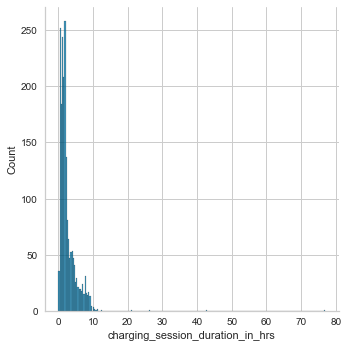

In [11]:
sns.displot(df['charging_session_duration_in_hrs'])

In [12]:
df_less_outliers = df[df['charging_session_duration_in_hrs'] <= 10]

In [13]:
n = 2
data_lost = (len(df_less_outliers) / len(df)) * 100
print("After removing outliers, we have {0:.{1}f} percent of the data we began with.".format(data_lost, n))

After removing outliers, we have 83.72 percent of the data we began with.


<AxesSubplot:xlabel='kWhDelivered', ylabel='charging_session_duration_in_hrs'>

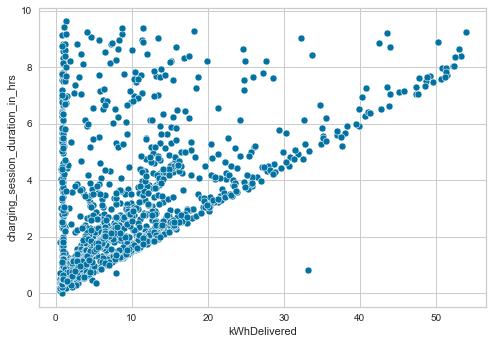

In [14]:
sns.scatterplot(data=df_less_outliers, x='kWhDelivered', y='charging_session_duration_in_hrs')

The scatterplot reveals a fundamental property of the problem: the relationship between how much energy is delivered, and how long it takes to receive that energy is positively correlated - but not strongly enough to provide predictive value. Stated simply, it's not as linear as one would hope/expect. 

In a solar installation, for example, the energy delivered to the meter is almost perfectly linear with the amount of solar resource available; if you plot energy delivered (on a sunny day), the signature will mirror the rise and all of the sun. Modeling and measurement uncertainy combined tends to hover around 5-8%.

We don't see that linearity here. Our plot shows that for a user to have 15 kWh of charge, it could take two and a half hours - but it could just as easily take six. There is a limit to how fast a vehicle can be charged - but there's no upper bound. Physics would explain the lower boundary. We do not yet know what covariate(s) explain the variance above the hard lower bound.

We would not have access to kWh_delivered in a production environment since it is a product of our target variable, so we will omit it this feature from the model (directly). Nevertheless, the graph is helpful for illustrative purposes.

As an aside, the vector of zeros on the X axis is also interesting. There are a considerable number of sessions where the vehicle is supposedly charging - but it is not registering kWh delivered. 

In [ ]:
X,y = df_less_outliers['kWhDelivered'], df_less_outliers['charging_session_duration_in_hrs']
X = X.values.reshape(-1,1)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

NameError: name 'X' is not defined

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

In [ ]:
lr.score(X_test, y_test)

We now have a baseline. High bias, low variance. 

In [ ]:
y_pred = lr.predict(X_test)
y_true = y_test

In [ ]:
mean_absolute_error(y_pred,y_test)

We can intepret our current state as "Our model can predict to the hour - give or take an hour." 

In [ ]:
res_plot = ResidualsPlot(lr)
res_plot.fit(X_train, y_train)  
res_plot.score(X_test, y_test)
res_plot.show()

The distribution of our residuals reveals an important quality of the problem. Ideally, the residual plot would be normally distributed. But the current distribution is skewed to the right, like our target distribution. What this ultimately translates to is that we need to find the signal in the data for how and why charging sessions go long (as reflected in the long tail) - and then feed that to the model so that it may learn. That signal may not be present in the features available here, but we will see what we can find.

In [110]:
df.userInputs[0]

[{'WhPerMile': 400,
  'kWhRequested': 24.0,
  'milesRequested': 60,
  'minutesAvailable': 125,
  'modifiedAt': 'Thu, 02 Jan 2020 01:13:30 GMT',
  'paymentRequired': True,
  'requestedDeparture': 'Thu, 02 Jan 2020 03:17:29 GMT',
  'userID': 1099}]

We know that ambient temperature has a marginal impact on the performance of the electrical components. Temperature on either extreme of hot or cold has a degrading effect. However, Pasadena has a Mediterranean climate that doesn't deviate far from the annual average of 64 degrees. I am confident the effect, if any, is negligable. 

In [20]:
user_input_sessions_df = df_less_outliers[df_less_outliers['userInputs'].notna()]

In [111]:
wh_from_input = [x[0]['WhPerMile'] for x in user_input_sessions_df['userInputs']]
energy_requested_from_input = [x[0]['kWhRequested'] for x in user_input_sessions_df['userInputs']]
miles_requested_from_input = [x[0]['milesRequested'] for x in user_input_sessions_df['userInputs']]
payment_required = [x[0]['paymentRequired'] for x in user_input_sessions_df['userInputs']]

In [22]:
user_input_sessions_df['wh_per_mile'] = pd.Series(wh_from_input)
user_input_sessions_df['energy_requested'] = pd.Series(energy_requested_from_input)
user_input_sessions_df['miles_requested_from_input'] = pd.Series(miles_requested_from_input)

/Users/toddhendricks/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/toddhendricks/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/toddhendricks/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [23]:
x = user_input_sessions_df['energy_requested']
y = user_input_sessions_df['kWhDelivered']
z = user_input_sessions_df['charging_session_duration_in_hrs']
potential_features = pd.concat([x,y,z], axis=1)

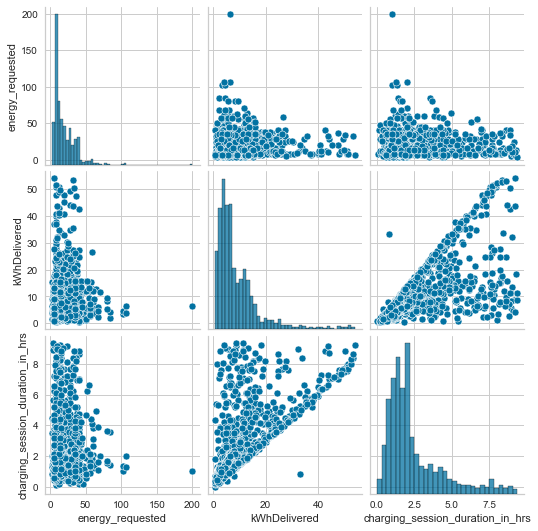

In [24]:
sns.pairplot(data=potential_features)

In [25]:
user_input_sessions_df['onboard_charger_avg_rating'] = 7

/Users/toddhendricks/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [26]:
user_input_sessions_df['charge_time_approximation'] = (user_input_sessions_df['wh_per_mile'] / user_input_sessions_df['onboard_charger_avg_rating']) * 0.9

/Users/toddhendricks/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [27]:
user_input_sessions_df.head(6)

,_id,clusterID,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,userInputs,charging_session_duration,charging_session_duration_in_hrs,wh_per_mile,energy_requested,miles_requested_from_input,onboard_charger_avg_rating,charge_time_approximation
0,5e225f9ff9af8b5c26d21718,0039,2020-01-02 01:12:00,"Thu, 02 Jan 2020 04:38:39 GMT",2020-01-02 03:11:00,8.336,2_39_126_20_2020-01-02 01:12:28.778216,0002,CA-310,2-39-126-20,America/Los_Angeles,000001099,"[{'WhPerMile': 400, 'kWhRequested': 24.0, 'mil...",-1 days +22:01:00,1.983333,400.0,24.0,60.0,7,51.428571
1,5e225f9ff9af8b5c26d21719,0039,2020-01-02 04:18:00,"Fri, 03 Jan 2020 00:06:13 GMT",2020-01-02 06:41:00,14.731,2_39_79_382_2020-01-02 04:18:06.407434,0002,CA-491,2-39-79-382,America/Los_Angeles,000003267,"[{'WhPerMile': 400, 'kWhRequested': 40.0, 'mil...",-1 days +21:37:00,2.383333,400.0,40.0,100.0,7,51.428571
2,5e23b122f9af8b5fe4b973bf,0039,2020-01-02 16:05:00,"Fri, 03 Jan 2020 00:11:51 GMT",2020-01-02 16:39:00,2.083,2_39_79_380_2020-01-02 16:05:14.818106,0002,CA-489,2-39-79-380,America/Los_Angeles,000000751,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile...",-1 days +23:26:00,0.566667,400.0,8.0,20.0,7,51.428571
4,5e23b122f9af8b5fe4b973c1,0039,2020-01-02 16:31:00,"Fri, 03 Jan 2020 00:29:28 GMT",2020-01-03 00:29:00,50.788,2_39_78_366_2020-01-02 16:31:34.854057,0002,CA-323,2-39-78-366,America/Los_Angeles,000003853,"[{'WhPerMile': 360, 'kWhRequested': 64.8, 'mil...",-1 days +16:02:00,7.966667,400.0,12.0,30.0,7,51.428571
5,5e23b122f9af8b5fe4b973c2,0039,2020-01-02 17:25:00,"Fri, 03 Jan 2020 02:14:55 GMT",2020-01-02 19:23:00,4.187,2_39_138_29_2020-01-02 17:25:52.764723,0002,CA-304,2-39-138-29,America/Los_Angeles,000000620,"[{'WhPerMile': 400, 'kWhRequested': 12.0, 'mil...",-1 days +22:02:00,1.966667,600.0,12.0,20.0,7,77.142857
6,5e23b122f9af8b5fe4b973c3,0039,2020-01-02 17:45:00,"Fri, 03 Jan 2020 00:51:06 GMT",2020-01-02 19:55:00,6.874,2_39_78_367_2020-01-02 17:45:12.995970,0002,CA-494,2-39-78-367,America/Los_Angeles,000001001,"[{'WhPerMile': 600, 'kWhRequested': 12.0, 'mil...",-1 days +21:50:00,2.166667,400.0,8.0,20.0,7,51.428571


In [33]:
user_input_sessions_df = user_input_sessions_df.dropna()
X = user_input_sessions_df[['energy_requested','miles_requested_from_input','charge_time_approximation']]
y = user_input_sessions_df['charging_session_duration_in_hrs']
X = X.values

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [35]:
multiple_lr = LinearRegression()

In [36]:
multiple_lr.fit(X_train, y_train)

LinearRegression()

In [37]:
multiple_lr.score(X_test, y_test)

-0.009499137987110107

In [38]:
median_session_by_user = user_input_sessions_df.groupby(['userID'])['charging_session_duration_in_hrs'].median()

In [39]:
median_session_by_user

userID
000000022    3.675000
000000067    6.625000
000000068    4.616667
000000069    1.991667
000000171    2.066667
               ...   
000005758    1.333333
000005768    4.058333
000005855    1.183333
000006049    2.650000
000006097    0.666667
Name: charging_session_duration_in_hrs, Length: 138, dtype: float64

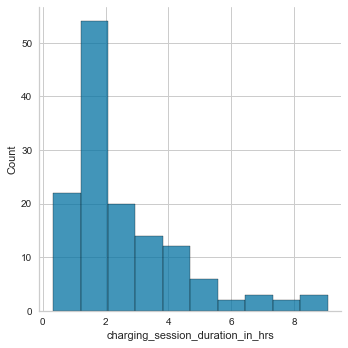

In [40]:
sns.displot(median_session_by_user)

In [41]:
median_session_by_user_dict = dict(median_session_by_user)

In [42]:
user_input_sessions_df['median_session_by_user'] = user_input_sessions_df['userID'].map(median_session_by_user_dict)

In [43]:
user_input_sessions_df.head(5)

,_id,clusterID,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,...,userID,userInputs,charging_session_duration,charging_session_duration_in_hrs,wh_per_mile,energy_requested,miles_requested_from_input,onboard_charger_avg_rating,charge_time_approximation,median_session_by_user
0,5e225f9ff9af8b5c26d21718,0039,2020-01-02 01:12:00,"Thu, 02 Jan 2020 04:38:39 GMT",2020-01-02 03:11:00,8.336,2_39_126_20_2020-01-02 01:12:28.778216,0002,CA-310,2-39-126-20,...,000001099,"[{'WhPerMile': 400, 'kWhRequested': 24.0, 'mil...",-1 days +22:01:00,1.983333,400.0,24.0,60.0,7,51.428571,2.300000
1,5e225f9ff9af8b5c26d21719,0039,2020-01-02 04:18:00,"Fri, 03 Jan 2020 00:06:13 GMT",2020-01-02 06:41:00,14.731,2_39_79_382_2020-01-02 04:18:06.407434,0002,CA-491,2-39-79-382,...,000003267,"[{'WhPerMile': 400, 'kWhRequested': 40.0, 'mil...",-1 days +21:37:00,2.383333,400.0,40.0,100.0,7,51.428571,2.366667
2,5e23b122f9af8b5fe4b973bf,0039,2020-01-02 16:05:00,"Fri, 03 Jan 2020 00:11:51 GMT",2020-01-02 16:39:00,2.083,2_39_79_380_2020-01-02 16:05:14.818106,0002,CA-489,2-39-79-380,...,000000751,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile...",-1 days +23:26:00,0.566667,400.0,8.0,20.0,7,51.428571,0.533333
4,5e23b122f9af8b5fe4b973c1,0039,2020-01-02 16:31:00,"Fri, 03 Jan 2020 00:29:28 GMT",2020-01-03 00:29:00,50.788,2_39_78_366_2020-01-02 16:31:34.854057,0002,CA-323,2-39-78-366,...,000003853,"[{'WhPerMile': 360, 'kWhRequested': 64.8, 'mil...",-1 days +16:02:00,7.966667,400.0,12.0,30.0,7,51.428571,7.533333
5,5e23b122f9af8b5fe4b973c2,0039,2020-01-02 17:25:00,"Fri, 03 Jan 2020 02:14:55 GMT",2020-01-02 19:23:00,4.187,2_39_138_29_2020-01-02 17:25:52.764723,0002,CA-304,2-39-138-29,...,000000620,"[{'WhPerMile': 400, 'kWhRequested': 12.0, 'mil...",-1 days +22:02:00,1.966667,600.0,12.0,20.0,7,77.142857,2.008333


In [44]:
last_lr = LinearRegression()

In [45]:
user_input_sessions_df = user_input_sessions_df.dropna()

In [46]:
X = user_input_sessions_df[['energy_requested','median_session_by_user','miles_requested_from_input', 'charge_time_approximation']]
y = user_input_sessions_df['charging_session_duration_in_hrs']
X = X.values

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [48]:
last_lr.fit(X_train, y_train)

LinearRegression()

In [49]:
last_lr.score(X_test, y_test)

0.5348637492709478

In [50]:
xgb_regressor = xgb.XGBRegressor(n_jobs=1).fit(X_train, y_train)

In [51]:
xgb_regressor.score(X_test, y_test)

0.20760599363995658

In [52]:
forty_three = df[df['userID'] == '000000743']
seventy = df[df['userID'] == '000001470']
sixty_six = df[df['userID'] == '000001366']
oh_one = df[df['userID'] == '000004701']
top_users = pd.concat([forty_three,seventy,sixty_six,oh_one])

In [53]:
top_users_condensed = top_users[['userID','charging_session_duration_in_hrs','kWhDelivered']]

In [55]:
top_users_condensed.head(5)

,userID,charging_session_duration_in_hrs,kWhDelivered
12,000000743,1.150000,3.399
20,000000743,1.466667,4.426
45,000000743,1.566667,4.689
66,000000743,1.466667,4.293
85,000000743,1.366667,4.073


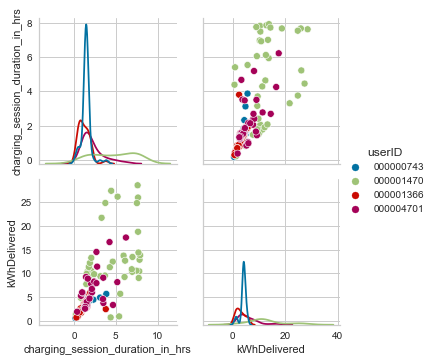

In [56]:
g = sns.PairGrid(top_users_condensed, hue="userID")
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

In [57]:
user_input_sessions_df.head(5)

,_id,clusterID,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,...,userID,userInputs,charging_session_duration,charging_session_duration_in_hrs,wh_per_mile,energy_requested,miles_requested_from_input,onboard_charger_avg_rating,charge_time_approximation,median_session_by_user
0,5e225f9ff9af8b5c26d21718,0039,2020-01-02 01:12:00,"Thu, 02 Jan 2020 04:38:39 GMT",2020-01-02 03:11:00,8.336,2_39_126_20_2020-01-02 01:12:28.778216,0002,CA-310,2-39-126-20,...,000001099,"[{'WhPerMile': 400, 'kWhRequested': 24.0, 'mil...",-1 days +22:01:00,1.983333,400.0,24.0,60.0,7,51.428571,2.300000
1,5e225f9ff9af8b5c26d21719,0039,2020-01-02 04:18:00,"Fri, 03 Jan 2020 00:06:13 GMT",2020-01-02 06:41:00,14.731,2_39_79_382_2020-01-02 04:18:06.407434,0002,CA-491,2-39-79-382,...,000003267,"[{'WhPerMile': 400, 'kWhRequested': 40.0, 'mil...",-1 days +21:37:00,2.383333,400.0,40.0,100.0,7,51.428571,2.366667
2,5e23b122f9af8b5fe4b973bf,0039,2020-01-02 16:05:00,"Fri, 03 Jan 2020 00:11:51 GMT",2020-01-02 16:39:00,2.083,2_39_79_380_2020-01-02 16:05:14.818106,0002,CA-489,2-39-79-380,...,000000751,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile...",-1 days +23:26:00,0.566667,400.0,8.0,20.0,7,51.428571,0.533333
4,5e23b122f9af8b5fe4b973c1,0039,2020-01-02 16:31:00,"Fri, 03 Jan 2020 00:29:28 GMT",2020-01-03 00:29:00,50.788,2_39_78_366_2020-01-02 16:31:34.854057,0002,CA-323,2-39-78-366,...,000003853,"[{'WhPerMile': 360, 'kWhRequested': 64.8, 'mil...",-1 days +16:02:00,7.966667,400.0,12.0,30.0,7,51.428571,7.533333
5,5e23b122f9af8b5fe4b973c2,0039,2020-01-02 17:25:00,"Fri, 03 Jan 2020 02:14:55 GMT",2020-01-02 19:23:00,4.187,2_39_138_29_2020-01-02 17:25:52.764723,0002,CA-304,2-39-138-29,...,000000620,"[{'WhPerMile': 400, 'kWhRequested': 12.0, 'mil...",-1 days +22:02:00,1.966667,600.0,12.0,20.0,7,77.142857,2.008333


In [61]:
median_energy_delivered = user_input_sessions_df.groupby(['userID'])['kWhDelivered'].median()
median_energy_delivered_dict = dict(median_energy_delivered)

In [62]:
user_input_sessions_df['median_energy_delivered'] = user_input_sessions_df['userID'].map(median_energy_delivered_dict)

In [63]:
user_input_sessions_df.head(5)

,_id,clusterID,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,...,userInputs,charging_session_duration,charging_session_duration_in_hrs,wh_per_mile,energy_requested,miles_requested_from_input,onboard_charger_avg_rating,charge_time_approximation,median_session_by_user,median_energy_delivered
0,5e225f9ff9af8b5c26d21718,0039,2020-01-02 01:12:00,"Thu, 02 Jan 2020 04:38:39 GMT",2020-01-02 03:11:00,8.336,2_39_126_20_2020-01-02 01:12:28.778216,0002,CA-310,2-39-126-20,...,"[{'WhPerMile': 400, 'kWhRequested': 24.0, 'mil...",-1 days +22:01:00,1.983333,400.0,24.0,60.0,7,51.428571,2.300000,14.1440
1,5e225f9ff9af8b5c26d21719,0039,2020-01-02 04:18:00,"Fri, 03 Jan 2020 00:06:13 GMT",2020-01-02 06:41:00,14.731,2_39_79_382_2020-01-02 04:18:06.407434,0002,CA-491,2-39-79-382,...,"[{'WhPerMile': 400, 'kWhRequested': 40.0, 'mil...",-1 days +21:37:00,2.383333,400.0,40.0,100.0,7,51.428571,2.366667,13.8970
2,5e23b122f9af8b5fe4b973bf,0039,2020-01-02 16:05:00,"Fri, 03 Jan 2020 00:11:51 GMT",2020-01-02 16:39:00,2.083,2_39_79_380_2020-01-02 16:05:14.818106,0002,CA-489,2-39-79-380,...,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile...",-1 days +23:26:00,0.566667,400.0,8.0,20.0,7,51.428571,0.533333,1.9205
4,5e23b122f9af8b5fe4b973c1,0039,2020-01-02 16:31:00,"Fri, 03 Jan 2020 00:29:28 GMT",2020-01-03 00:29:00,50.788,2_39_78_366_2020-01-02 16:31:34.854057,0002,CA-323,2-39-78-366,...,"[{'WhPerMile': 360, 'kWhRequested': 64.8, 'mil...",-1 days +16:02:00,7.966667,400.0,12.0,30.0,7,51.428571,7.533333,15.7990
5,5e23b122f9af8b5fe4b973c2,0039,2020-01-02 17:25:00,"Fri, 03 Jan 2020 02:14:55 GMT",2020-01-02 19:23:00,4.187,2_39_138_29_2020-01-02 17:25:52.764723,0002,CA-304,2-39-138-29,...,"[{'WhPerMile': 400, 'kWhRequested': 12.0, 'mil...",-1 days +22:02:00,1.966667,600.0,12.0,20.0,7,77.142857,2.008333,5.3635


In [64]:
med_ed_lr = LinearRegression()

In [65]:
X = user_input_sessions_df[['energy_requested','median_session_by_user','miles_requested_from_input', 'charge_time_approximation','median_energy_delivered']]
y = user_input_sessions_df['charging_session_duration_in_hrs']
X = X.values

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [67]:
med_ed_lr.fit(X_train, y_train)

LinearRegression()

In [68]:
med_ed_lr.score(X_test, y_test)

0.5313500981577806

In [108]:
user_transposed = user_input_sessions_df.transpose()

In [109]:
user_transposed

,0,1,2,4,5,6,7,8,9,10,...,1584,1585,1587,1588,1590,1591,1592,1593,1594,1595
_id,5e225f9ff9af8b5c26d21718,5e225f9ff9af8b5c26d21719,5e23b122f9af8b5fe4b973bf,5e23b122f9af8b5fe4b973c1,5e23b122f9af8b5fe4b973c2,5e23b122f9af8b5fe4b973c3,5e23b122f9af8b5fe4b973c4,5e23b122f9af8b5fe4b973c5,5e23b122f9af8b5fe4b973c6,5e23b122f9af8b5fe4b973c7,...,5e6d771af9af8b40886ec466,5e6d771af9af8b40886ec467,5e6d771af9af8b40886ec469,5e6d771af9af8b40886ec46a,5e6d771af9af8b40886ec46c,5e6d771af9af8b40886ec46d,5e6d771af9af8b40886ec46e,5e6d771af9af8b40886ec46f,5e6d771af9af8b40886ec470,5e6d771af9af8b40886ec471
clusterID,0039,0039,0039,0039,0039,0039,0039,0039,0039,0039,...,0039,0039,0039,0039,0039,0039,0039,0039,0039,0039
connectionTime,2020-01-02 01:12:00,2020-01-02 04:18:00,2020-01-02 16:05:00,2020-01-02 16:31:00,2020-01-02 17:25:00,2020-01-02 17:45:00,2020-01-02 17:46:00,2020-01-02 17:47:00,2020-01-02 18:07:00,2020-01-02 18:25:00,...,2020-02-27 15:56:00,2020-02-27 15:56:00,2020-02-27 16:20:00,2020-02-27 16:26:00,2020-02-27 16:34:00,2020-02-27 16:41:00,2020-02-27 16:43:00,2020-02-27 16:48:00,2020-02-27 16:48:00,2020-02-27 16:53:00
disconnectTime,"Thu, 02 Jan 2020 04:38:39 GMT","Fri, 03 Jan 2020 00:06:13 GMT","Fri, 03 Jan 2020 00:11:51 GMT","Fri, 03 Jan 2020 00:29:28 GMT","Fri, 03 Jan 2020 02:14:55 GMT","Fri, 03 Jan 2020 00:51:06 GMT","Thu, 02 Jan 2020 21:02:06 GMT","Thu, 02 Jan 2020 20:42:59 GMT","Thu, 02 Jan 2020 20:46:38 GMT","Fri, 03 Jan 2020 00:46:32 GMT",...,"Fri, 28 Feb 2020 01:27:50 GMT","Thu, 27 Feb 2020 22:47:21 GMT","Thu, 27 Feb 2020 22:11:48 GMT","Fri, 28 Feb 2020 00:43:36 GMT","Thu, 27 Feb 2020 23:14:47 GMT","Fri, 28 Feb 2020 02:27:33 GMT","Fri, 28 Feb 2020 00:07:32 GMT","Thu, 27 Feb 2020 22:47:38 GMT","Fri, 28 Feb 2020 03:12:36 GMT","Thu, 27 Feb 2020 22:54:10 GMT"
doneChargingTime,2020-01-02 03:11:00,2020-01-02 06:41:00,2020-01-02 16:39:00,2020-01-03 00:29:00,2020-01-02 19:23:00,2020-01-02 19:55:00,2020-01-02 19:49:00,2020-01-02 20:42:00,2020-01-02 19:32:00,2020-01-02 20:41:00,...,2020-02-28 00:46:00,2020-02-27 20:36:00,2020-02-27 22:11:00,2020-02-27 20:49:00,2020-02-27 21:55:00,2020-02-27 20:36:00,2020-02-27 21:54:00,2020-02-27 20:36:00,2020-02-27 20:36:00,2020-02-27 22:54:00
kWhDelivered,8.336,14.731,2.083,50.788,4.187,6.874,6.501,20.165,4.32,5.191,...,2.75,3.316,15.803,0.690823,1.978,4.535,13.09,2.448,5.388,7.524
sessionID,2_39_126_20_2020-01-02 01:12:28.778216,2_39_79_382_2020-01-02 04:18:06.407434,2_39_79_380_2020-01-02 16:05:14.818106,2_39_78_366_2020-01-02 16:31:34.854057,2_39_138_29_2020-01-02 17:25:52.764723,2_39_78_367_2020-01-02 17:45:12.995970,2_39_78_365_2020-01-02 17:46:14.843193,2_39_139_28_2020-01-02 17:47:52.598587,2_39_123_23_2020-01-02 18:07:56.928051,2_39_79_381_2020-01-02 18:25:20.402594,...,2_39_78_366_2020-02-27 15:56:01.732189,2_39_79_382_2020-02-27 15:56:05.803259,2_39_79_376_2020-02-27 16:20:21.547525,2_39_78_364_2020-02-27 16:26:27.472403,2_39_78_365_2020-02-27 16:34:29.507240,2_39_139_28_2020-02-27 16:41:32.839982,2_39_79_377_2020-02-27 16:43:25.755640,2_39_130_31_2020-02-27 16:48:23.053669,2_39_127_19_2020-02-27 16:48:45.871865,2_39_78_361_2020-02-27 16:52:56.199674
siteID,0002,0002,0002,0002,0002,0002,0002,0002,0002,0002,...,0002,0002,0002,0002,0002,0002,0002,0002,0002,0002
spaceID,CA-310,CA-491,CA-489,CA-323,CA-304,CA-494,CA-321,CA-303,CA-313,CA-490,...,CA-323,CA-491,CA-324,CA-495,CA-321,CA-303,CA-325,CA-306,CA-309,CA-493
stationID,2-39-126-20,2-39-79-382,2-39-79-380,2-39-78-366,2-39-138-29,2-39-78-367,2-39-78-365,2-39-139-28,2-39-123-23,2-39-79-381,...,2-39-78-366,2-39-79-382,2-39-79-376,2-39-78-364,2-39-78-365,2-39-139-28,2-39-79-377,2-39-130-31,2-39-127-19,2-39-78-361


In [106]:
user_transposed.groupby()

32159.370102782406

<img src="files/station.jpg">

Thanks for taking the time to review my work! Any feedback, questions, comments, or feedback is most welcome. You can reach me on Linkedin, or via email: hendricks.ta@gmail.com